In [36]:
!pip install xgboost

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df = pd.read_csv("cab_rides.csv")
df

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL
...,...,...,...,...,...,...,...,...,...,...
693066,1.00,Uber,1543708385534,North End,West End,13.0,1.0,616d3611-1820-450a-9845-a9ff304a4842,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL
693067,1.00,Uber,1543708385534,North End,West End,9.5,1.0,633a3fc3-1f86-4b9e-9d48-2b7132112341,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX
693068,1.00,Uber,1543708385534,North End,West End,NaN,1.0,64d451d0-639f-47a4-9b7c-6fd92fbd264f,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi
693069,1.00,Uber,1543708385534,North End,West End,27.0,1.0,727e5f07-a96b-4ad1-a2c7-9abc3ad55b4e,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV


In [7]:
df.isnull().sum()

distance                0
cab_type                0
time_stamp              0
destination             0
source                  0
price               55095
surge_multiplier        0
id                      0
product_id              0
name                    0
dtype: int64

In [8]:
df = df.dropna(subset=['price'])
df = df.drop(columns=['id'])

In [9]:
df.shape

(637976, 9)

In [10]:
df.isnull().sum()

distance            0
cab_type            0
time_stamp          0
destination         0
source              0
price               0
surge_multiplier    0
product_id          0
name                0
dtype: int64

In [11]:
# Convert timestamp (assuming milliseconds)

df['time_stamp'] = pd.to_datetime(df['time_stamp'], unit='ms')

df['hour'] = df['time_stamp'].dt.hour
df['day_of_week'] = df['time_stamp'].dt.dayofweek      ### 0= Monday  6=Sunday
df['month'] = df['time_stamp'].dt.month

df = df.drop(columns=['time_stamp'])


In [12]:
### Check the new columns

df.head()

,distance,cab_type,destination,source,price,surge_multiplier,product_id,name,hour,day_of_week,month
0,0.44,Lyft,North Station,Haymarket Square,5.0,1.0,lyft_line,Shared,9,6,12
1,0.44,Lyft,North Station,Haymarket Square,11.0,1.0,lyft_premier,Lux,2,1,11
2,0.44,Lyft,North Station,Haymarket Square,7.0,1.0,lyft,Lyft,1,2,11
3,0.44,Lyft,North Station,Haymarket Square,26.0,1.0,lyft_luxsuv,Lux Black XL,4,4,11
4,0.44,Lyft,North Station,Haymarket Square,9.0,1.0,lyft_plus,Lyft XL,3,3,11


In [13]:
categorical_cols = ['cab_type', 'destination', 'source', 'product_id', 'name']

# One-hot encoding (drop_first=True to avoid dummy variable trap)
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Confirm changes
df.head()


,distance,price,surge_multiplier,hour,day_of_week,month,cab_type_Uber,destination_Beacon Hill,destination_Boston University,destination_Fenway,...,name_Lux,name_Lux Black,name_Lux Black XL,name_Lyft,name_Lyft XL,name_Shared,name_UberPool,name_UberX,name_UberXL,name_WAV
0,0.44,5.0,1.0,9,6,12,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1,0.44,11.0,1.0,2,1,11,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
2,0.44,7.0,1.0,1,2,11,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3,0.44,26.0,1.0,4,4,11,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,0.44,9.0,1.0,3,3,11,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


In [14]:
### Split the data for train and test

X = df.drop('price', axis=1)
y = df['price']

In [15]:
### train and Test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)


RandomForestRegressor(n_jobs=-1, random_state=42)

In [17]:
# Predict on test set
y_pred = rf_model.predict(X_test)

# RMSE (manually)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

In [18]:
print("RMSE Score :",rmse)
print("R2 Score :",r2)

RMSE Score : 1.7984751621775923
R2 Score : 0.9628986323698633


In [19]:
xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=6, random_state=42)  # Extreme Gradient Boosting
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

In [20]:
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)


In [21]:
print("RMSE Score :",rmse_xgb)
print("R2 Score :",r2_xgb)

RMSE Score : 1.6325872266294836
R2 Score : 0.9694272983186236


In [22]:
import pickle

# Save the trained Random Forest model to a file
with open("cab_price_model.pkl", "wb") as f:
    pickle.dump(rf_model, f)


In [23]:
# Load the saved model
with open("cab_price_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)


In [24]:
import pandas as pd
import numpy as np
import pickle
from datetime import datetime

# Load saved model
with open("cab_price_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

# Function to predict price for a new ride
def predict_cab_price(distance, cab_type, source, destination, time_stamp, surge_multiplier):
    # Convert timestamp to datetime
    dt = datetime.fromtimestamp(time_stamp / 1000)  # assuming ms timestamp
    hour = dt.hour
    day_of_week = dt.weekday()  # 0=Monday
    month = dt.month
    
    # Engineered features
    distance_surge = distance * surge_multiplier
    peak_hour = 1 if 7 <= hour <= 10 or 17 <= hour <= 20 else 0
    is_weekend = 1 if day_of_week >= 5 else 0

    # Start with zeros for all columns
    X_new = pd.DataFrame(columns=loaded_model.feature_names_in_)
    X_new.loc[0] = 0

    # Fill numeric columns
    for col, val in [('distance', distance), 
                     ('surge_multiplier', surge_multiplier), 
                     ('hour', hour), 
                     ('day_of_week', day_of_week),
                     ('month', month),
                     ('distance_surge', distance_surge),
                     ('peak_hour', peak_hour),
                     ('is_weekend', is_weekend)]:
        if col in X_new.columns:
        # Cast float/int properly
            if np.issubdtype(X_new[col].dtype, np.integer):
                X_new.at[0, col] = int(val)
            else:
                X_new.at[0, col] = float(val)

    # Fill one-hot columns
    cab_col = f'cab_type_{cab_type}'
    if cab_col in X_new.columns:
        X_new.at[0, cab_col] = 1

    dest_col = f'destination_{destination}'
    if dest_col in X_new.columns:
        X_new.at[0, dest_col] = 1

    source_col = f'source_{source}'
    if source_col in X_new.columns:
        X_new.at[0, source_col] = 1

    name_col = f'name_{cab_type}'  # adjust if your dataset has a separate name column
    if name_col in X_new.columns:
        X_new.at[0, name_col] = 1

    # Predict price
    predicted_price = loaded_model.predict(X_new)[0]
    return predicted_price


In [25]:
# Example prediction
price = predict_cab_price(
    distance=10,
    cab_type='Uber',
    source='Boston University',
    destination='Haymarket Square',
    time_stamp=1544952607890,
    surge_multiplier=1.2
)

print("Predicted price:", price)


Predicted price: 17.4275


In [26]:
# Example rides (list of dicts)
new_rides = [
    {"distance": 3.0, "cab_type": "Uber", "source": "Haymarket Square", "destination": "Fenway", "time_stamp": 1544952607890, "surge_multiplier": 1.0},
    {"distance": 1.2, "cab_type": "Lyft", "source": "North Station", "destination": "Beacon Hill", "time_stamp": 1544952607890, "surge_multiplier": 1.2}
]

# Predict for each ride
for ride in new_rides:
    price = predict_cab_price(**ride)
    print(f"Predicted price for {ride['cab_type']} ride from {ride['source']} to {ride['destination']}: {price:.2f}")


Predicted price for Uber ride from Haymarket Square to Fenway: 10.68
Predicted price for Lyft ride from North Station to Beacon Hill: 7.08


In [75]:
# Create a dictionary with ride details and predicted price
ride = {
    'distance': 10,
    'cab_type': 'Uber',
    'source': 'Boston University',
    'destination': 'Haymarket Square',
    'time_stamp': 1544952607890,
    'surge_multiplier': 1.2,
    'predicted_price': price
}

# Convert to DataFrame
df_new = pd.DataFrame([ride])

# Try reading existing CSV
try:
    df_pred = pd.read_csv("predicted_price.csv")
except FileNotFoundError:
    df_pred = pd.DataFrame()  # create empty DataFrame if file doesn't exist

# Append new prediction
df_pred = pd.concat([df_pred, df_new], ignore_index=True)

# Save back to CSV
df_pred.to_csv("predicted_price.csv", index=False)

print("Predicted price appended to predicted_price.csv")


Predicted price appended to predicted_price.csv


**----------------------------------------------------------------**

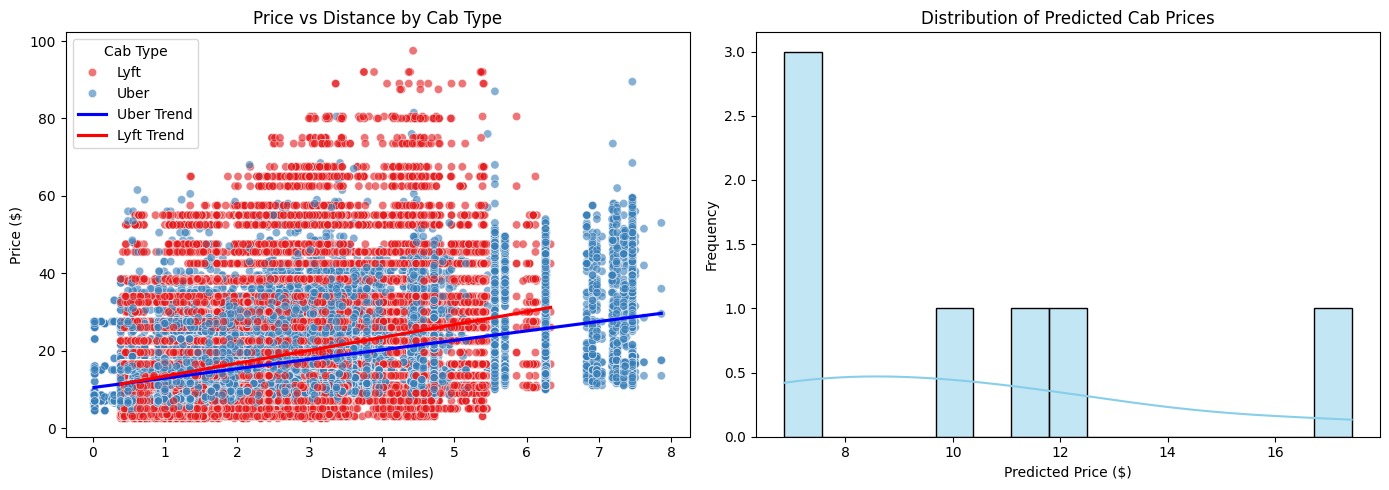

In [76]:
#  comparing original dataset vs predicted data

# Load datasets
df_original = pd.read_csv("cab_rides.csv")           # original data
df_predicted = pd.read_csv("predicted_price.csv")   # predicted prices

# Create a figure with 2 subplots
plt.figure(figsize=(14,5))

# --- Left subplot: Price vs Distance with trend line ---
plt.subplot(1,2,1)
sns.scatterplot(x='distance', y='price', hue='cab_type', data=df_original, palette='Set1', alpha=0.6)
sns.regplot(x='distance', y='price', data=df_original[df_original['cab_type']=='Uber'], scatter=False, color='blue', label='Uber Trend')
sns.regplot(x='distance', y='price', data=df_original[df_original['cab_type']=='Lyft'], scatter=False, color='red', label='Lyft Trend')
plt.title("Price vs Distance by Cab Type")
plt.xlabel("Distance (miles)")
plt.ylabel("Price ($)")
plt.legend(title="Cab Type")

# --- Right subplot: Predicted Prices Distribution ---
plt.subplot(1,2,2)
sns.histplot(df_predicted['predicted_price'], bins=15, kde=True, color='skyblue')
plt.title("Distribution of Predicted Cab Prices")
plt.xlabel("Predicted Price ($)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


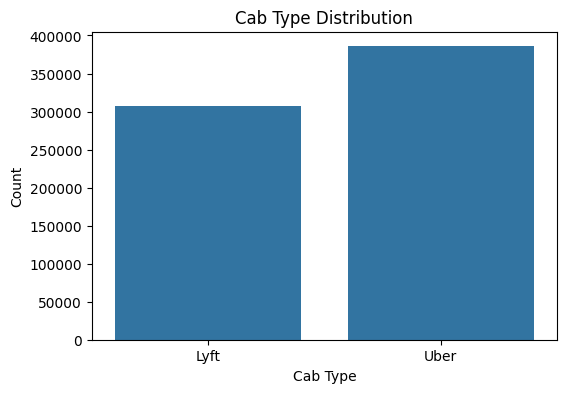

In [79]:
#  Cab Type Distribution

plt.figure(figsize=(6,4))
sns.countplot(x='cab_type', data=df)  # Categorical Distribution
plt.title("Cab Type Distribution")
plt.xlabel("Cab Type")
plt.ylabel("Count")
plt.show()


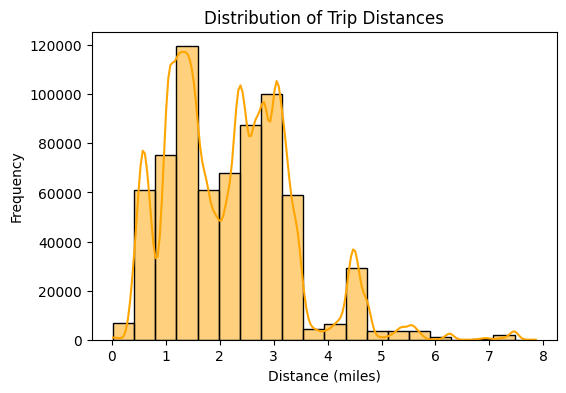

In [80]:
#  Distance Distribution

plt.figure(figsize=(6,4))
sns.histplot(df['distance'], bins=20, kde=True, color='orange')     # Right-Skewed Distribution
plt.title("Distribution of Trip Distances")
plt.xlabel("Distance (miles)")
plt.ylabel("Frequency")
plt.show()


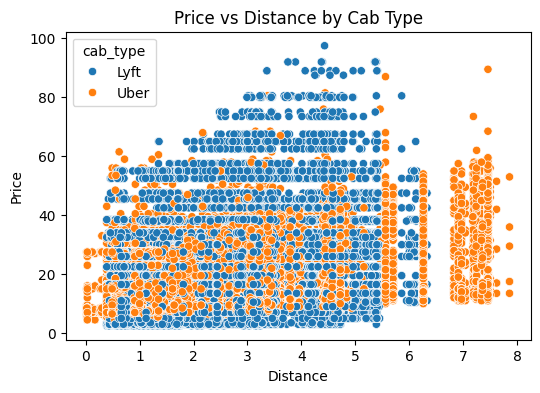

In [81]:
#  Price vs Distance by cab type

plt.figure(figsize=(6,4))
sns.scatterplot(x='distance', y='price', hue='cab_type', data=df)
plt.title("Price vs Distance by Cab Type")
plt.xlabel("Distance")
plt.ylabel("Price")
plt.show()


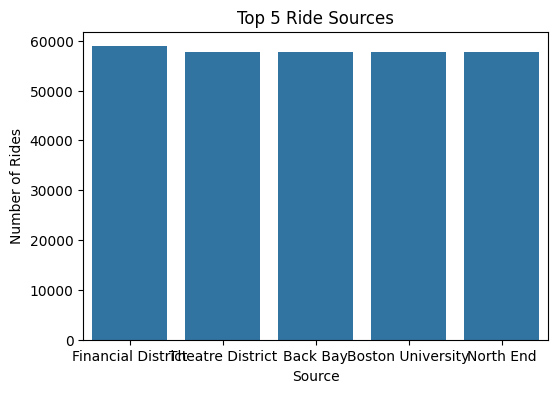

In [83]:
#  Top 5 Ride Sources

plt.figure(figsize=(6,4))
sns.barplot(x=top_sources.index, y=top_sources.values)  # Categorical Distribution
plt.title("Top 5 Ride Sources")
plt.xlabel("Source")
plt.ylabel("Number of Rides")
plt.show()


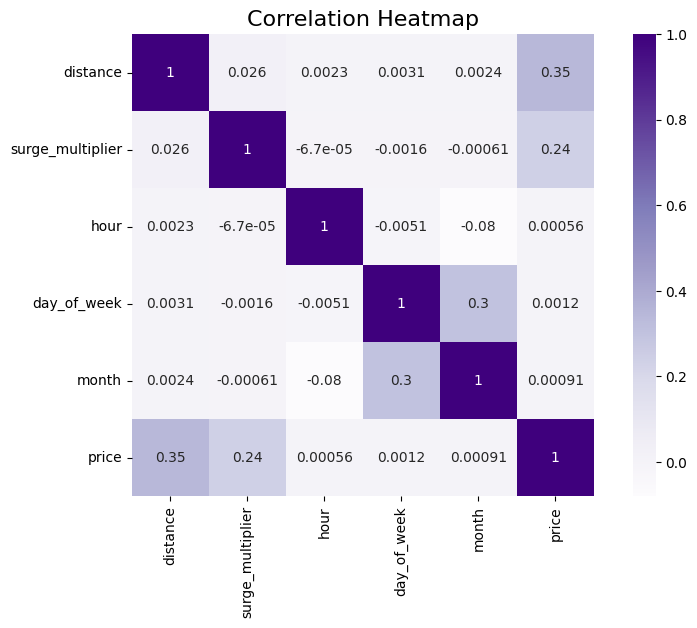

In [33]:
important_cols = ['distance', 'surge_multiplier', 'hour', 'day_of_week', 'month', 'price']

# Compute correlation for selected columns
corr = df[important_cols].corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap="Purples", cbar=True, square=True)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

<Axes: ylabel='price'>

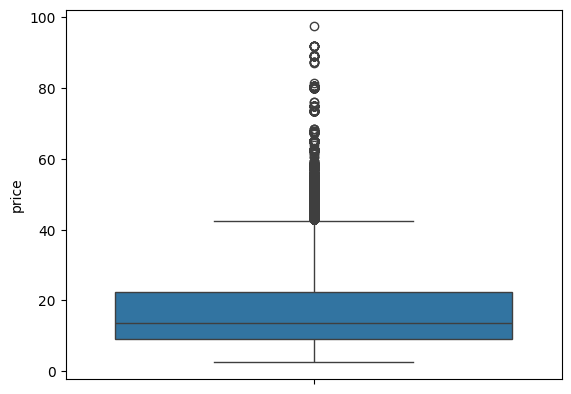

In [4]:
sns.boxplot(data = df, y = "price")